#  Multiple Linear Regression from Scratch

In this notebook, I implement Multiple Linear Regression using pure NumPy to predict diabetes progression based on 7 different clinical features.

Unlike the single-feature version, this implementation focuses on Vectorization. Instead of using slow for loops to calculate predictions and gradients for each feature, I use Matrix Algebra (np.dot) to process all features and examples simultaneously.

### **Importing the necessary libraries:**

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

### **Importing the Dataset:**

In [85]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

## **Dataset description:**

In [86]:
print("Dataset Description:")
print(diabetes.DESCR)

print("\nFeature Names:")
print(diabetes.feature_names)

print("\nFirst 10 rows of data (features):")
print(diabetes.data[:10])

print("\nFirst 10 rows of target:")
print(diabetes.target[:10])

Dataset Description:
.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 featu

### **Understanding the data:**

In [87]:
# List of column indices we want to KEEP
# (sex, bmi, bp, s2, s3, s5, s6)
columns_to_keep = [1, 2, 3, 5, 6, 8, 9]


X_train = diabetes.data[:, columns_to_keep]


y_train = diabetes.target[:]


print(f"New X_train shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y_train shape: {y_train.shape}, y Type:{type(y_train)})")

New X_train shape: (442, 7), X Type:<class 'numpy.ndarray'>)
y_train shape: (442,), y Type:<class 'numpy.ndarray'>)


### **Displaying the data in a graph:**

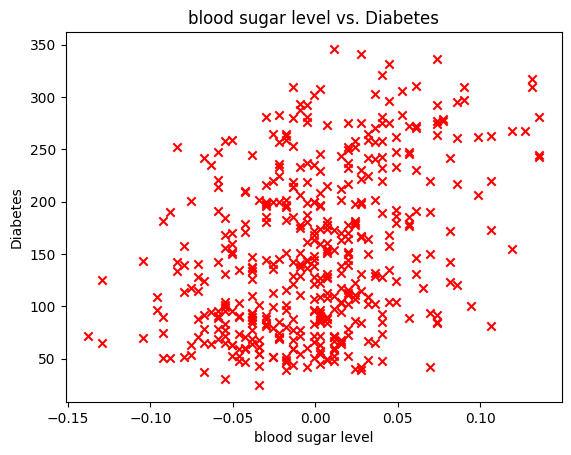

In [88]:

plt.scatter(X_train[:,-1], y_train, marker='x', c='r')

plt.title("blood sugar level vs. Diabetes")

plt.ylabel('Diabetes')

plt.xlabel('blood sugar level')
plt.show()


## **Model Prediction Function**

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b $$
**Vectorized notation:**
$$f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$$


### **Parameter Initialization for Testing**
We initialize arbitrary values for weights ($\mathbf{w}$) and bias ($b$) to verify if the dimensions match our data before training.

In [89]:
b_init = 152.13
w_init = np.array([619.2168, 619.2168, 619.2168, 619.2168, 619.2168, 619.2168, 619.2168])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (7,), b_init type: <class 'float'>


### **Implementing the cost function with np.dot:**

In [90]:
def predict(x, w, b):

    # p (scalar):  prediction

    p = np.dot(x, w) + b
    return p

In [91]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")


x_vec shape (7,), x_vec value: [ 0.05068012  0.06169621  0.02187239 -0.03482076 -0.04340085  0.01990749
 -0.01764613]
f_wb shape (), prediction: 188.22319571750222



## **Compute Cost With Multiple Variables**
Cost function:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 $$
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b $$



In [92]:
def compute_cost(X, y, w, b):

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar
    return cost

In [93]:
# Compute and display cost using our pre-chosen optimal parameters.
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 4152.041605258437



## **Gradient Descent With Multiple Variables**


$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}   \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

Parameters $w_j$,  $b$, are updated simultaneously.

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$


  

### **Gradient implementation:**


In [100]:
def compute_gradient(X,y, w, b):
    m,n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        f_wb = np.dot(X[i], w) + b
        err = f_wb - y[i]

        for j in range (n):
            dj_dw[j] += err * X[i,j]

        dj_db += err

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw


In [101]:
#Compute and display gradient
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_dw at initial w,b: \n {tmp_dj_db}\n')
print(f'dj_db at initial w,b:{tmp_dj_dw}')

dj_dw at initial w,b: 
 -0.003484162896006933

dj_db at initial w,b:[1.87471742 0.9519179  1.78319954 2.16696659 0.33453315 1.25313106
 2.05771267]



## **Gradient Descent With Multiple Variables**

In [102]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):

    # An array to store cost J and w's
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):

        dj_db,dj_dw = gradient_function(X, y, w, b)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:
            J_history.append(cost_function(X, y, w, b))

        # Print cost every at intervals 10 times
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}")

    return w, b, J_history #return final w,b and J

In [105]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 10000
alpha = 0.1
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient,alpha, iterations)

print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")




Iteration    0: Cost 12336.90
Iteration 1000: Cost  2020.36
Iteration 2000: Cost  1708.38
Iteration 3000: Cost  1588.48
Iteration 4000: Cost  1532.73
Iteration 5000: Cost  1501.97
Iteration 6000: Cost  1482.95
Iteration 7000: Cost  1470.46
Iteration 8000: Cost  1462.01
Iteration 9000: Cost  1456.20
b,w found by gradient descent: 152.13,[-185.53736961  490.21684705  298.5667592   -64.06697944 -266.23490413
  435.47188206  123.21204991] 


## **Viewing the results:**

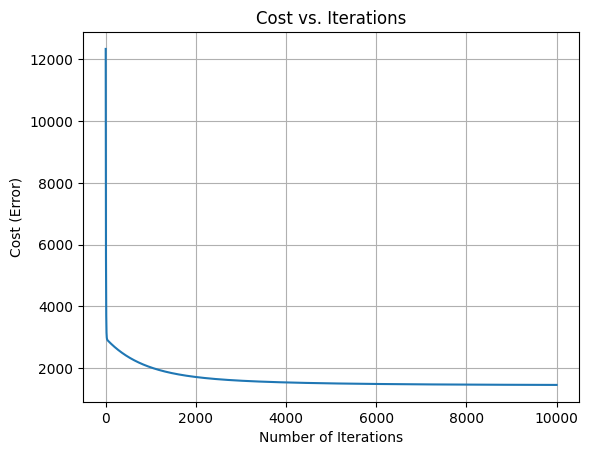

In [107]:

plt.plot(J_hist)


plt.title("Cost vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost (Error)")
plt.grid(True)


plt.show()

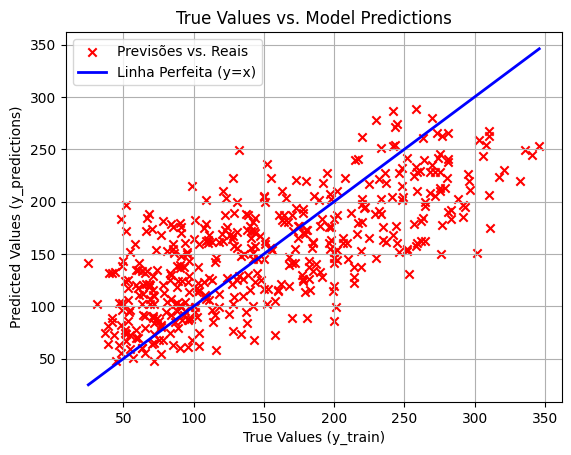

In [120]:

y_predictions = np.dot(X_train, w_final) + b_final

plt.scatter(y_train, y_predictions, marker='x', c='r', label='Previsões vs. Reais')


min_val = min(min(y_train), min(y_predictions))
max_val = max(max(y_train), max(y_predictions))

plt.plot([min_val, max_val], [min_val, max_val], c='b', lw=2, label='Linha Perfeita (y=x)')

plt.title("True Values vs. Model Predictions")
plt.xlabel("True Values (y_train)")
plt.ylabel("Predicted Values (y_predictions)")
plt.legend()
plt.grid(True)
plt.show()

## **Final Model Evaluation:**

In [122]:
from sklearn.metrics import r2_score

# Calculate R-squared score
r2 = r2_score(y_train, y_predictions)

print(f"--- Model Performance Metrics (10 Features) ---")
print(f"Final Cost (MSE): {J_hist[-1]:.2f}")
print(f"R-squared (R²): {r2:.4f}")

--- Model Performance Metrics (10 Features) ---
Final Cost (MSE): 1452.19
R-squared (R²): 0.5102


### 📊 Performance Analysis

**1. R-squared (0.51):**
The model explains approximately **51% of the variance** in the target variable (disease progression).
* **Interpretation:** For a simple Linear Regression model on complex clinical data, this is a reasonable baseline result. It indicates a moderate correlation between the 7 physiological features used and the disease progression, but suggests that the relationship might not be entirely linear or that other unmeasured factors influence the outcome.

**2. Final Cost / MSE (1452.19):**
The Mean Squared Error represents the average squared difference between predictions and actual values.
* **Magnitude:** Taking the square root ($$\sqrt{1452} \approx 38.1$$), we can say that, on average, our model's predictions deviate by about **38 points** from the actual diabetes progression score (which ranges from roughly 25 to 346).

**Conclusion:**
The vectorized implementation successfully converged and learned a valid relationship, proving the correctness of the Gradient Descent algorithm implemented from scratch. To improve beyond $$R^2 \approx 0.51$$, future work could explore non-linear models (Polynomial Regression) or more complex algorithms like Random Forest or Neural Networks.